## Import all what we need.

In [1]:
# encoding: utf-8
import os
import bz2
import csv
import math
import glob
import time
import pylab
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from numba import jit
from io import StringIO
import matplotlib.pyplot as plt

D:\Downloads\Python\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [3]:
def inp_para(inp_filepath):
    
    inp_col_name = ['c0', 'c1', 'c2']
    inp_df = pd.read_csv(inp_filepath, sep='\\s+', names=inp_col_name, header=None)
    col0 = inp_df['c0']
    database = inp_df[col0.isin(['Database'])]['c1'].values[0]
    molecule = inp_df[col0.isin(['Molecule'])]['c1'].values[0]
    isotopologue = inp_df[col0.isin(['Isotopologue'])]['c1'].values
    dataset = inp_df[col0.isin(['Dataset'])]['c1'].values
    mol_iso_id = int(inp_df[col0.isin(['mol_iso_id'])]['c1'])
    T = int(inp_df[col0.isin(['Temperature'])]['c1'])
    min_wn = float(inp_df[col0.isin(['Range'])]['c1'])
    max_wn = float(inp_df[col0.isin(['Range'])]['c2'])
    N_point = int(inp_df[col0.isin(['Npoints'])]['c1'])
    profile = inp_df[col0.isin(['Profile'])]['c1'].values[0]
    saveplots = inp_df[col0.isin(['SavePlots'])]['c1'].values[0]
    savexsecs = inp_df[col0.isin(['SaveXsecs'])]['c1'].values[0]

    molecule_id = int(mol_iso_id/10)
    isotopologue_id = mol_iso_id - molecule_id * 10
    isometa_url = 'https://hitran.org/docs/iso-meta/'
    iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
    iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
    abundance = float(iso_meta_row['Abundance'][0].replace('\xa0×\xa010','E'))
    mass = float(iso_meta_row['Molar Mass /g·mol-1'])
    Q_ref = float(iso_meta_row.loc[0][6].replace('\xa0×\xa010','E'))
    Q_url = 'https://hitran.org/data/Q/' + iso_meta_row.loc[0][7]
    Q_content = requests.get(Q_url).text
    Q_col_name = ['T', 'Q']
    Q_df = pd.read_csv(StringIO(Q_content), sep='\\s+', names=Q_col_name, header=None)
    Q = Q_df['Q'][T - 1]
    
    return database, molecule, isotopologue, dataset, T, min_wn, max_wn, N_point, profile, saveplots, savexsecs, molecule_id, isotopologue_id, abundance, mass, Q_ref, Q


In [4]:
inp_filepath = 'NO__T500__2000-10000__Lorentzian__ExoMol.inp'
read_path = '../data/www.exomol.com/db/'
(database, molecule, isotopologue, dataset, T, min_wn, max_wn, N_point, profile, 
 saveplots, savexsecs, molecule_id, isotopologue_id, abundance, mass, Q_ref, Q) = inp_para(inp_filepath)

# Parameters for calculating.
import astropy.constants as ac
T_ref = 296                     # Reference temperature is 296 K.
P_ref = 1                       # Reference pressure is 1 atm.
P = 1
N_A = ac.N_A.value              # Avogadro number (mol^{-1})
h = ac.h.to('J s').value        # Planck's const (J s)
c = ac.c.to('cm/s').value       # Velocity of light (cm s^{-1})
kB = ac.k_B.to('J/K').value     # Boltzmann's const (J K^{-1})

c2 = h * c / kB                 # Second radiation constant (cm K)
c2_T = c2 / T                   # c2 / T (cm)
c2_T_ref = c2 / T_ref           # c2 / T_ref (cm)
pi_c_8 = 1 / (8 * np.pi * c)    # 8 * pi * c (cm-1 s)

ratio = 1
ratio_air = 0.7
ratio_self = 0.3
cutoff = 25.0


In [6]:
def read_all_states(read_path):
    
    s_df = dict()
    states_df = pd.DataFrame()
    states_filenames = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset 
                                  + '/' + isotopologue + '__' + dataset + '.states.bz2')[0])

    for states_filename in states_filenames:
        s_df[states_filename] = pd.read_csv(states_filename, compression='bz2', sep='\s+', header=None,
                                            chunksize=100_000_000, iterator=True, low_memory=False)
        for chunk in s_df[states_filename]:
            # Extract rows of states file whose uncertainty indices are small than 0.01.
            #chunk = chunk[chunk[4] < float(0.01)]
            states_df = states_df.append(chunk)
            
    pd.set_option("display.max_columns",30)                           
    return(states_df)

In [7]:
read_all_states(read_path)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,0.000000,6,0.5,inf,-0.000767,+,e,X1/2,0,1,-0.5,0.5,e
1,2,1876.076228,6,0.5,0.083086,-0.000767,+,e,X1/2,1,1,-0.5,0.5,e
2,3,3724.066346,6,0.5,0.042467,-0.000767,+,e,X1/2,2,1,-0.5,0.5,e
3,4,5544.020643,6,0.5,0.028936,-0.000767,+,e,X1/2,3,1,-0.5,0.5,e
4,5,7335.982597,6,0.5,0.022179,-0.000767,+,e,X1/2,4,1,-0.5,0.5,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21683,21684,51438.064160,1104,183.5,2.392600,0.005317,-,e,X3/2,0,-1,-0.5,-1.5,c
21684,21685,51423.235338,1110,184.5,2.260000,0.005289,+,e,X1/2,0,1,-0.5,0.5,c
21685,21686,51925.238545,1110,184.5,2.139500,-0.005201,+,e,X3/2,0,1,0.5,1.5,c
21686,21687,51423.246295,1110,184.5,2.139400,-0.005204,-,f,X1/2,0,-1,0.5,-0.5,c


In [25]:
def read_all_trans(read_path):
    
    t_df = dict()
    trans_df = pd.DataFrame()
    trans_col_name = ['i', 'f', 'A_if', 'v_if']
    trans_filenames = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')[0])

    for trans_filename in trans_filenames:
        t_df[trans_filename] = pd.read_csv(trans_filename, compression='bz2', sep='\s+', header=None,
                                           names=trans_col_name, chunksize=100_000_000, iterator=True, low_memory=False)
        for chunk in t_df[trans_filename]:
            #chunk = chunk[chunk['v_if'] >= min_wn]
            #chunk = chunk[chunk['v_if'] <= max_wn]
            trans_df = trans_df.append(chunk)
            
    pd.set_option("display.max_columns",30)                           
    return(trans_df)
    

In [26]:
read_all_trans(read_path)

,i,f,A_if,v_if
0,200,303,1.683600e-28,0.000011
1,202,305,1.287100e-28,0.000011
2,206,309,1.818900e-28,0.000011
3,188,291,5.813000e-26,0.000012
4,190,293,1.865400e-26,0.000012
...,...,...,...,...
2280361,14152,13893,3.609900e-17,40026.317941
2280362,14087,14223,4.034600e-15,40028.429745
2280363,14153,14157,4.035300e-15,40028.732188
2280364,14416,14158,2.539700e-18,40039.004060


In [10]:
def read_trans(read_path):
    t_df = dict()
    trans_df = pd.DataFrame()
    lower_df = pd.DataFrame()
    upper_df = pd.DataFrame()
    insider_df = pd.DataFrame()
    trans_col_name = ['i', 'f', 'A_if', 'v_if']
    trans_filenames = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')[0])

    if len(trans_filenames) == 1:
        t_df = pd.read_csv(trans_filenames[0], compression='bz2', sep='\s+', header=None, 
                           names=trans_col_name, chunksize=100_000_000, iterator=True, low_memory=False)
        for chunk in t_df:
            chunk = chunk[chunk['v_if'] >= min_wn]
            chunk = chunk[chunk['v_if'] <= max_wn]
            trans_df = trans_df.append(chunk)
        
    else:
        for trans_filename in tqdm(trans_filenames):
            lower = int(trans_filename.split('__')[2].split('.')[0].split('-')[0])
            upper = int(trans_filename.split('__')[2].split('.')[0].split('-')[1])
            if (lower <= int(min_wn) <= upper):
                file_lower = pd.read_csv(trans_filename, compression='bz2', sep='\s+', names=trans_col_name, 
                                         header=None, chunksize=100_000_000, iterator=True, low_memory=False)
                for chunk in file_lower:
                    chunk = chunk[chunk['v_if'] >= min_wn]
                    chunk = chunk[chunk['v_if'] <= max_wn]
                    lower_df = trans_df.append(chunk)

            elif (lower <= int(min_wn) <= upper):
                file_upper = pd.read_csv(trans_filename, compression='bz2', sep='\s+', names=trans_col_name, 
                                         header=None, chunksize=100_000_000, iterator=True, low_memory=False)
                for chunk in file_upper:
                    chunk = chunk[chunk['v_if'] >= min_wn]
                    chunk = chunk[chunk['v_if'] <= max_wn]                  
                    upper_df = trans_df.append(chunk)

            elif (lower >= int(min_wn) and upper <= int(max_wn)):    
                t_df[trans_filename] = pd.read_csv(trans_filename, compression='bz2', sep='\s+', names=trans_col_name, 
                                                   header=None, chunksize=100_000_000, iterator=True, low_memory=False)
                for chunk in tqdm(t_df[trans_filename]):
                    insider_df = trans_df.append(chunk)       

        trans_df = lower_df.append(insider_df).append(upper_df)
    return (trans_df)

In [11]:
read_trans(read_path)

,i,f,A_if,v_if
274360,407,491,0.000059,2000.023744
274361,4596,4493,0.001850,2000.033076
274362,16843,17002,0.000113,2000.036423
274363,510,388,0.000059,2000.049983
274364,4866,5154,0.010647,2000.052931
...,...,...,...,...
986853,13669,13585,0.061383,9999.919490
986854,14770,14692,0.000002,9999.927802
986855,19588,19458,0.002335,9999.934803
986856,18045,17881,0.018754,9999.953486


In [12]:
def read_pf(read_path, T_ref, T):
    
    pf_url = ('http://www.exomol.com/db/' + molecule + '/' + isotopologue + '/' + dataset 
              + '/' + isotopologue + '__' + dataset + '.pf')[0]
    pf_content = requests.get(pf_url).text
    pf_col_name = ['T', 'Q']
    pf_df = pd.read_csv(StringIO(pf_content), sep='\\s+', names=pf_col_name, header=None)
    Q_ref = pf_df['Q'][T_ref-1]
    Q = pf_df['Q'][T-1]

    return(Q_ref, Q)

In [13]:
Q_ref, Q = read_pf(read_path, T_ref, T)
Q

2117.972

In [14]:
def read_broad(read_path):
    
    broad_col_name = ['code', 'gamma_L', 'n_air', 'Jpp']
    broad_path = (read_path + molecule + '/' + isotopologue + '__air.broad')[0]
    broad_df = pd.read_csv(broad_path, sep='\s+', names=broad_col_name, header=None, engine='python')
    return(broad_df)

In [15]:
read_broad(read_path)  

,code,gamma_L,n_air,Jpp
0,a0,0.06691,0.7,0.5
1,a0,0.06461,0.7,1.5
2,a0,0.06258,0.7,2.5
3,a0,0.06082,0.7,3.5
4,a0,0.05930,0.7,4.5
...,...,...,...,...
174,a0,0.04500,0.7,174.5
175,a0,0.04500,0.7,175.5
176,a0,0.04500,0.7,176.5
177,a0,0.04500,0.7,177.5


In [16]:
def all_linelist(read_path):
    states_df = read_all_states(read_path)
    trans_df = read_all_trans(read_path)
    
    id_i = trans_df['i'].values
    id_f = trans_df['f'].values
    states_i_df = states_df.iloc[id_i-1]
    states_f_df = states_df.iloc[id_f-1]
    
    linelist_df = pd.DataFrame()
    linelist_df['i'] = trans_df['i']
    linelist_df['f'] = trans_df['f']
    linelist_df['A'] = trans_df['A_if']
    linelist_df['v'] = trans_df['v_if']
    linelist_df['Ep'] = states_i_df[1].values
    linelist_df['gp'] = states_i_df[2].values
    
    return linelist_df


In [17]:
all_linelist_df = all_linelist(read_path)
all_linelist_df

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.18s/it]


,i,f,A,v,Ep,gp
0,200,303,1.683600e-28,0.000011,51758.545382,12
1,202,305,1.287100e-28,0.000011,51836.445168,12
2,206,309,1.818900e-28,0.000011,52027.855858,12
3,188,291,5.813000e-26,0.000012,51035.893950,12
4,190,293,1.865400e-26,0.000012,51305.627368,12
...,...,...,...,...,...,...
2280361,14152,13893,3.609900e-17,40026.317941,50572.228642,486
2280362,14087,14223,4.034600e-15,40028.429745,51097.881881,486
2280363,14153,14157,4.035300e-15,40028.732188,51098.237842,486
2280364,14416,14158,2.539700e-18,40039.004060,51401.261539,498


In [18]:
def linelist(read_path):
    states_df = read_all_states(read_path)
    trans_df = read_trans(read_path)
    broad_df = read_broad(read_path)
    
    id_i = trans_df['i'].values
    id_f = trans_df['f'].values
    states_i_df = states_df.iloc[id_i-1]
    states_f_df = states_df.iloc[id_f-1]
    max_broad_J = max(broad_df['Jpp'])
    
    linelist_df = pd.DataFrame()
    linelist_df['i'] = trans_df['i']
    linelist_df['f'] = trans_df['f']
    linelist_df['A'] = trans_df['A_if']
    linelist_df['v'] = trans_df['v_if']
    linelist_df['Ep'] = states_i_df[1].values
    linelist_df['Epp'] = states_f_df[1].values
    linelist_df['gp'] = states_i_df[2].values
    #linelist_df['gpp'] = states_f_df[2].values
    linelist_df['Jpp'] = states_f_df[3].values
    linelist_df['Jpp'][linelist_df.Jpp > max_broad_J] = max_broad_J
    id_broad = linelist_df['Jpp'] - 0.5
    linelist_df['gamma_L'] = broad_df['gamma_L'][id_broad].values
    linelist_df['n_air'] = broad_df['n_air'][id_broad].values
    
    return linelist_df


In [19]:
linelist_df = linelist(read_path)
linelist_df

D:\Downloads\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,i,f,A,v,Ep,Epp,gp,Jpp,gamma_L,n_air
274360,407,491,0.000059,2000.023744,51782.118545,49782.094801,18,2.5,0.06258,0.7
274361,4596,4493,0.001850,2000.033076,8399.355477,6399.322401,144,22.5,0.04718,0.7
274362,16843,17002,0.000113,2000.036423,39841.735204,37841.698781,624,104.5,0.04500,0.7
274363,510,388,0.000059,2000.049983,51782.144729,49782.094746,18,2.5,0.06258,0.7
274364,4866,5154,0.010647,2000.052931,51102.435341,49102.382410,150,25.5,0.04285,0.7
...,...,...,...,...,...,...,...,...,...,...
986853,13669,13585,0.061383,9999.919490,43386.274689,33386.355199,468,76.5,0.04500,0.7
986854,14770,14692,0.000002,9999.927802,35610.217351,25610.289549,516,85.5,0.04500,0.7
986855,19588,19458,0.002335,9999.934803,49831.431214,39831.496411,798,131.5,0.04500,0.7
986856,18045,17881,0.018754,9999.953486,51395.027433,41395.073947,690,113.5,0.04500,0.7


# Parition Function


In [17]:
Ntemp = 1
Tmax = int(5000.00)

# Partition function
def exomol_partition_func(read_path):
    start = time.clock()
    
    states_df = read_all_states(read_path)
    E_n = states_df[1]
    g_n = states_df[2]
    J_n = states_df[3]
    pf_list = []

    for T in (range(0, Tmax+1, Ntemp)):
        partition_func_1 = np.sum(g_n * np.exp(-c2 * E_n / T))
        partition_func_2 = np.sum(g_n * (c2 * E_n / T) * np.exp(-c2 * E_n / T))
        partition_func_3 = np.sum(g_n * (c2 * E_n / T) ** 2 * np.exp(-c2 * E_n / T))
        
        pf_list.append(str(format(T, '13.3f') + ' ' + format(partition_func_1, '20.8E') + ' ' + format(partition_func_2, '20.8E') + ' ' + format(partition_func_3, '20.8E')))
        
    pf_path = (isotopologue + '__' + dataset + '.pf')[0]
 
    with open(pf_path, 'w') as pf_file:
        for pf in pf_list:
            pf_file.write(pf + '\n')
        pf_file.close()
    
    end = time.clock()
    t = end - start
    print('Running time :', t, 's')
    print('Partition function has been saved!')  


In [18]:
exomol_partition_func(read_path)

D:\Downloads\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Running time : 35.87259059999997  s
Partition function has been saved!


D:\Downloads\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


# Cooling Function

In [27]:
Ntemp = 1
Tmax = int(500.00)

# Cooling function
def exomol_cooling_func(read_path):
    start = time.clock()
    
    linelist_df = all_linelist(read_path)
    A = linelist_df['A']
    v = linelist_df['v']
    Ep = linelist_df['Ep']      # Lower state energy
    gp = linelist_df['gp']      # Total degeneracy of lower state 
    cf_list = []
    for T in (range(Ntemp, Tmax+1, Ntemp)):
        Q_ref, Q = read_pf(read_path, T_ref, T)
        cooling_func = np.sum(A * h * c * v * gp * np.exp(-c2 * Ep / T)) / (4 * np.pi * Q) * 1e7
        cf_list.append(str(format(T, '13.3f') + ' ' + format(cooling_func, '20.8E')))
  
    cf_path = (read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + isotopologue + '__' + dataset + '.cooling')[0]
    
    with open(cf_path, 'w') as cf_file:
        for cf in cf_list:
            cf_file.write(cf + '\n')
        cf_file.close()
        
    end = time.clock()
    t = end - start
    print('Running time :', t, 's')
    print('Cooling function has been saved!')   
    


In [28]:
exomol_cooling_func(read_path)

D:\Downloads\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


KeyboardInterrupt: 

# Lifetime

In [20]:
# Lifetime
def exomol_lifetime(read_path):
    start = time.clock()
    
    states_df = read_all_states(read_path)
    trans_df = read_all_trans(read_path)
    sum_A = trans_df.groupby('i')['A_if'].sum()
    lifetime = 1 / sum_A
    lt_df = lifetime.map('{: >12.4E}'.format).reset_index()
    states_trans_df = states_df[0].append(lt_df['i'])
    states_trans_df = states_trans_df.drop_duplicates(keep=False)
    add_i = pd.DataFrame()
    add_i['i'] = states_trans_df
    add_i['A_if'] = ' -1.0000E+00'
    lifetime_df = lt_df.append(add_i, ignore_index=True)
    lifetime_df.sort_values('i',inplace=True)
    states_df.insert(5, 'lifetime', lifetime_df['A_if'].tolist())
    
    end = time.clock()
    t = end - start
    
    return(states_df)

In [21]:
lifetime = exomol_lifetime(read_path)
lifetime

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.32s/it]


,0,1,2,3,4,lifetime,5,6,7,8,9,10,11,12,13
0,1,0.000000,6,0.5,inf,-1.0000E+00,-0.000767,+,e,X1/2,0,1,-0.5,0.5,e
1,2,1876.076228,6,0.5,0.083086,8.3086E-02,-0.000767,+,e,X1/2,1,1,-0.5,0.5,e
2,3,3724.066346,6,0.5,0.042467,4.2467E-02,-0.000767,+,e,X1/2,2,1,-0.5,0.5,e
3,4,5544.020643,6,0.5,0.028936,2.8936E-02,-0.000767,+,e,X1/2,3,1,-0.5,0.5,e
4,5,7335.982597,6,0.5,0.022179,2.2179E-02,-0.000767,+,e,X1/2,4,1,-0.5,0.5,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21683,21684,51438.064160,1104,183.5,2.392600,2.2630E+00,0.005317,-,e,X3/2,0,-1,-0.5,-1.5,c
21684,21685,51423.235338,1110,184.5,2.260000,2.2600E+00,0.005289,+,e,X1/2,0,1,-0.5,0.5,c
21685,21686,51925.238545,1110,184.5,2.139500,2.1395E+00,-0.005201,+,e,X3/2,0,1,0.5,1.5,c
21686,21687,51423.246295,1110,184.5,2.139400,2.2599E+00,-0.005204,-,f,X1/2,0,-1,0.5,-0.5,c


In [22]:
lt_list = exomol_lifetime(read_path)
#lt_path = '../data/www.exomol.com/db/' + path_mol_iso + '/' + path_mol_iso.split('/')[1] + '__' + path_mol_iso.split('/')[2] + '.csv'
lt_path = (read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + isotopologue + '__' + dataset + '.csv')[0]

lifetime.to_csv(lt_path, header=None, index=False, chunksize = 1000)
print('lifetime has been saved!')   

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.32s/it]


lifetime has been saved!


In [20]:
@jit
def Doppler_HWHM (v, mass, T):
    '''Return the Doppler half-width at half-maximum (HWHM) -- alpha.'''
    alpha = np.sqrt(2 * N_A * kB * T * np.log(2) / mass) * v / c
    return alpha

@jit
def Lorentzian_HWHM (T, P, n_air, gamma_L):
    '''Return the Lorentzian half-width at half-maximum (HWHM) -- gamma.'''
    #gamma = ((T_ref / T)**n_air * gamma_air * ratio_air + (T_ref / T)**n_self * gamma_self * ratio_self)  * (P / P_ref)
    gamma = gamma_L * ratio * (T_ref / T)**n_air * (P / P_ref)
    return gamma

@jit
def Gaussian_profile(dv, alpha):
    '''Return Gaussian line profile at dv with HWHM alpha.'''
    Gaussian_profile = np.sqrt(np.log(2) / np.pi) / alpha * np.exp(-(dv / alpha)**2 * np.log(2))
    #Gaussian_profile = np.exp(-(dv / alpha)**2 / 2) / alpha / np.sqrt(2 * np.pi)
    return Gaussian_profile

@jit
def Lorentzian_profile(dv, gamma):
    '''Return Lorentzian line profile at dv with HWHM gamma.'''
    Lorentzian_profile = gamma / np.pi / (dv**2 + gamma**2)
    return Lorentzian_profile


In [21]:
from scipy.special import voigt_profile
@jit
def scipy_Voigt_profile(dv, alpha, gamma):
    '''
    Return the Voigt line profile with 
    Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.

    '''
    return voigt_profile(dv, alpha, gamma)

In [22]:
def exomol_cross_section(read_path):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with line profiles.
    
    '''
    linelist_df = linelist(read_path)
    nlines = len(linelist_df)
    wn_grid = np.linspace(min_wn - cutoff, max_wn + cutoff, N_point)
    A = linelist_df['A']
    v = linelist_df['v']
    Epp = linelist_df['Epp']      # Lower state energy
    gp = linelist_df['gp']        # Total degeneracy of upper state
    gamma_L = linelist_df['gamma_L']
    n_air = linelist_df['n_air']
    
    alpha = Doppler_HWHM (v, mass, T)
    gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)
    abscoef = gp * A * np.exp(- c2_T * Epp) * (1 - np.exp(- c2_T * v)) * pi_c_8 / (v ** 2) / Q * abundance    
    return (nlines, wn_grid, v, alpha, gamma, abscoef)

In [23]:
@jit
def exomol_cross_section_Lorentzian():
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Lorentzian profile.
    
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = exomol_cross_section(read_path)
    xsec_l = np.zeros_like(wn_grid)

    for i in tqdm(range(nlines)):
        
        v = vs.values[i]
        gamma = gammas.values[i]
        abscoef = abscoefs.values[i]
        
        dv = wn_grid - v
        xsec_l += abscoef * Lorentzian_profile(dv, gamma)

    return (wn_grid, xsec_l)

In [24]:
@jit
def exomol_cross_section_scipy_Voigt():
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with scipy Voigt profile.
    
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = exomol_cross_section(read_path)
    xsec_sv = np.zeros_like(wn_grid)

    for i in tqdm(range(nlines)):
        
        v = vs.values[i]
        alpha = alphas.values[i]
        gamma = gammas.values[i]
        abscoef = abscoefs.values[i]
        
        dv = wn_grid - v
        xsec_sv += abscoef * scipy_Voigt_profile(dv, alpha, gamma)

    return (wn_grid, xsec_sv)

In [25]:
def plot_exomol_xsec_Lorentzian():
    start = time.clock()
    (wn, xsec_l) = exomol_cross_section_Lorentzian()
    end = time.clock()
    t = end - start
    print('Running time :', t, 's')
    print('Temperature selected: ', T, 'K')
    print('Pressure selected: ', P, 'bar')
    #print('Air broading is: ', ratio_air)
    #print('Self broading is: ', ratio_self)
    print('Wavenumber range selected: ', min_wn, 'cm-1 - ', max_wn, 'cm-1')
    
    xsec_l_df = pd.DataFrame()
    xsec_l_df['wavenumber'] = wn
    xsec_l_df['cross-section'] = xsec_l
    xsec_filename = '../data/xsecs/NO/NO__T'+str(T)+'__'+str(min_wn)+'-'+str(max_wn)+'__Lorentzian__ExoMol.xsec'
    np.savetxt(xsec_filename, np.vstack((wn,xsec_l)).T)
    print('Saved xsec file.')
    
    fig = plt.figure(figsize=(12, 6))
    plt.plot(wn, xsec_l, label='T = 500 K, Lorentzian profile')
    plt.title('Molecule NO')
    plt.xlabel('Wavenumber, cm$^{-1}$')
    plt.ylabel('Cross-section, cm$^{2}$/molecule')
    plt.legend()
    plt.savefig('../data/plots/NO/NO__T'+str(T)+'__'+str(min_wn)+'-'+str(max_wn)+'__Lorentzian__ExoMol.png', dpi=500)
    plt.show()
    print('Saved xsec plots.')

In [26]:
def plot_exomol_xsec_scipy_Voigt():
    start = time.clock()
    (wn, xsec_sv) = exomol_cross_section_scipy_Voigt()
    end = time.clock()
    t = end - start
    print('Running time :', t, 's')
    print('Temperature selected: ', T, 'K')
    print('Pressure selected: ', P, 'bar')
    #print('Air broading is: ', ratio_air)
    #print('Self broading is: ', ratio_self)
    print('Wavenumber range selected: ', min_wn, 'cm-1 - ', max_wn, 'cm-1')
    
    xsec_sv_df = pd.DataFrame()
    xsec_sv_df['wavenumber'] = wn
    xsec_sv_df['cross-section'] = xsec_sv
    xsec_filename = '../data/xsecs/NO/NO__T'+str(T)+'__'+str(min_wn)+'-'+str(max_wn)+'__scipy_Voigt__ExoMol.xsec'
    np.savetxt(xsec_filename, np.vstack((wn,xsec_sv)).T)
    print('Saved xsec file.')
        
    fig = plt.figure(figsize=(12, 6))
    plt.plot(wn, xsec_sv, label='T = 500 K, Scipy Voigt profile')
    plt.title('Molecule NO')
    plt.xlabel('Wavenumber, cm$^{-1}$')
    plt.ylabel('Cross-section, cm$^{2}$/molecule')
    plt.legend()
    plt.savefig('../data/plots/NO/NO__T'+str(T)+'__'+str(min_wn)+'-'+str(max_wn)+'__scipy_Voigt__ExoMol.png')
    plt.show()
    print('Saved xsec plots.')

D:\Downloads\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
<ipython-input-23-f77ba6947736>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "exomol_cross_section_Lorentzian" failed type inference due to: Untyped global name 'exomol_cross_section': cannot determine Numba type of <class 'function'>

File "<ipython-input-23-f77ba6947736>", line 8:
def exomol_cross_section_Lorentzian():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = exomol_cross_section(read_path)
    ^

  @jit
<ipython-input-23-f77ba6947736>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "exomol_cross_section_Lorentzian" failed type inference due to: Untyped global name 'exomol_cross_section': cannot determine N

Running time : 180.29609399999993 s
Temperature selected:  500 K
Pressure selected:  1 bar
Wavenumber range selected:  2000.0 cm-1 -  10000.0 cm-1
Saved xsec file.


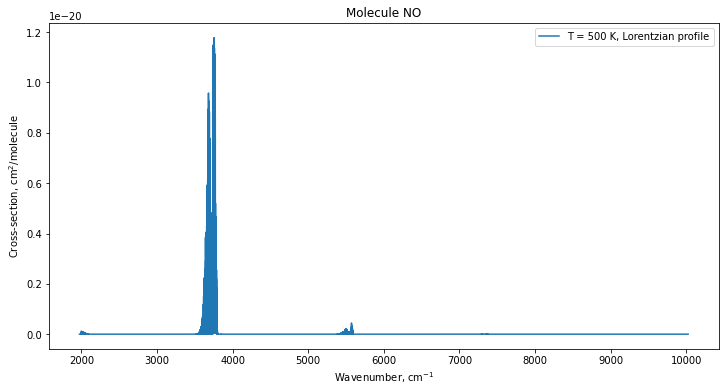

Saved xsec plots.


In [27]:
plot_exomol_xsec_Lorentzian()

In [ ]:
plot_exomol_xsec_scipy_Voigt()

D:\Downloads\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
<ipython-input-41-aff0e13af8f2>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "exomol_cross_section_scipy_Voigt" failed type inference due to: Untyped global name 'exomol_cross_section': cannot determine Numba type of <class 'function'>

File "<ipython-input-41-aff0e13af8f2>", line 8:
def exomol_cross_section_scipy_Voigt():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = exomol_cross_section(read_path)
    ^

  @jit
<ipython-input-41-aff0e13af8f2>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "exomol_cross_section_scipy_Voigt" failed type inference due to: Untyped global name 'exomol_cross_section': cannot determin

In [31]:
def plot_exomol_xsec_Lorentzian():
    start = time.clock()
    (wn, xsec_l) = exomol_cross_section_Lorentzian()
    wl = 10**7 / wn
    min_wl = 10**7 / min_wn
    max_wl = 10**7 / max_wn
    end = time.clock()
    t = end - start
    print('Running time :', t, 's')
    print('Temperature selected: ', T, 'K')
    print('Pressure selected: ', P, 'bar')
    #print('Air broading is: ', ratio_air)
    #print('Self broading is: ', ratio_self)
    print('Wavelength range selected: ', min_wl, 'nm - ', max_wl, 'nm')
    
    xsec_l_df = pd.DataFrame()
    xsec_l_df['wavelength'] = wl
    xsec_l_df['cross-section'] = xsec_l
    xsec_filename = '../data/xsecs/NO/NO__T'+str(T)+'__'+str(min_wl)+'-'+str(max_wl)+'__Lorentzian__ExoMol.xsec'
    np.savetxt(xsec_filename, np.vstack((wl,xsec_l)).T)
    print('Saved xsec file.')
    
    fig = plt.figure(figsize=(12, 6))
    plt.plot(wl, xsec_l, label='T = 500 K, Lorentzian profile')
    plt.title('Molecule NO')
    plt.xlabel('Wavelength, nm')
    plt.ylabel('Cross-section, cm$^{2}$/molecule')
    plt.legend()
    plt.savefig('../data/plots/NO/NO__T'+str(T)+'__'+str(min_wl)+'-'+str(max_wl)+'__Lorentzian__ExoMol.png', dpi=500)
    plt.show()
    print('Saved xsec plots.')

D:\Downloads\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
D:\Downloads\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|████████████████████████████████████████████████████████████████████████| 712498/712498 [02:38<00:00, 4499.89it/s]
D:\Downloads\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


Running time : 165.39394319999997 s
Temperature selected:  500 K
Pressure selected:  1 bar
Wavenumber range selected:  5000.0 nm -  1000.0 nm
Saved xsec file.


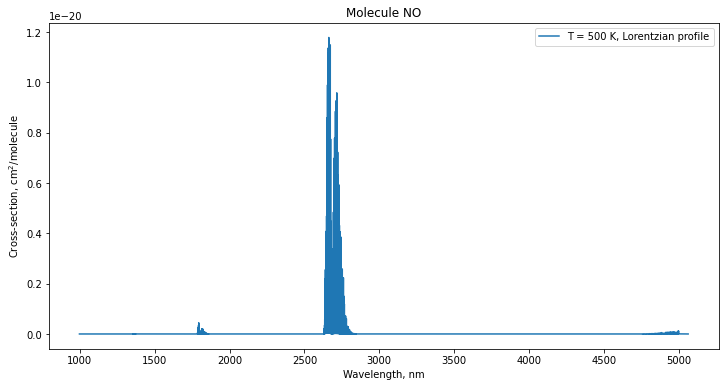

Saved xsec plots.


In [32]:
plot_exomol_xsec_Lorentzian()

300